<a href="https://colab.research.google.com/github/TeaWithLucas/MLBirds/blob/main/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
!pip install opencv
import cv2
import numpy as np
import re
import seaborn as sns
import operator
import math
import random
import datetime
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    from imageio import imread, imwrite
from PIL import Image
import tqdm.notebook as tq #just to provide visual feedback

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [3]:
import argparse

import sklearn.metrics

#using pretrained EfficientNetB7 model
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import tensorboard


In [4]:
git_fldr = 'MLBirds/'
%cd C:\GIT

if os.path.exists(git_fldr):
  %cd MLBirds
  !git pull
else:
  !git clone https://github.com/TeaWithLucas/MLBirds.git
  %cd MLBirds

import data_load as data

C:\GIT
C:\GIT\MLBirds
Updating bb340c97..192af411
Fast-forward
 analysis.ipynb | 76 ++++++++++++++++++++++++++++++----------------------------
 1 file changed, 39 insertions(+), 37 deletions(-)


From https://github.com/TeaWithLucas/MLBirds
   bb340c97..192af411  main       -> origin/main


# Devices Info

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9114288172945420280
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17852655429105962605
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


# Data functions

In [6]:

#image_size = 224 #EfficientNetB0
#image_size = 300 #EfficientNetB3
image_size = 456 #EfficientNetB5

img_fldr='images/'
process_fldr='processed/' # + str(image_size) + '/'

bound_fldr = process_fldr + 'bound/'
noise_fldr = process_fldr + 'noise/'
gamma_fldr = process_fldr + 'gamma/'
transpose_fldr = process_fldr + 'transpose/'
equalhist_fldr =  process_fldr + 'equalhist/'


def get_image_path(image_id, fldr=img_fldr):
  if fldr == img_fldr:
    rows = data.images.loc[data.images.image_id == image_id]
    return os.path.join(fldr,rows.image_name.values[0])
  else:
    return os.path.join(fldr,str(get_image_class_id(image_id)-1), str(image_id)+'.png')
  
def get_image(image_id, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return Image.open(path)

def get_cv2_image(image_id, flags=None, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return cv2.imread(path,flags)

def get_image_class_id(image_id):
  rows = data.image_class_labels.loc[data.image_class_labels.image_id == image_id]
  return rows.class_id.values[0]

def get_class_name(class_id):
  rows = data.classes.loc[data.classes.class_id == class_id]
  return rows.class_name.values[0]

def get_image_class_name(image_id):
  return get_class_name(get_image_class_id(test_id))

def get_bounding_box(image_id):
  rows = data.bounding_boxes.loc[data.bounding_boxes.image_id == image_id]
  return rows

def check_create_image_loc(path):
    if not os.path.exists(path):
      if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
      return True
    else:
      return False

#Visualization picture
def plt_img(img):
    img=np.array(img)
    plt.imshow(img)
    plt.show()

#Visualization picture
def plt_cv2_img(img):
    img=np.array(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def plot_grid_imgs(img_ids, fldrs=[img_fldr],samples=25):
  plt.figure(figsize=(10,10))
  rows = len(fldrs)
  cols = math.floor(samples/rows)
  for i, img_id in enumerate(random.choices(img_ids, k=cols)):
    for j, fldr in enumerate(fldrs):
      if rows==1:
        plt.subplot(5,samples/5,i+j+1)
      else:
        cell = (i)*cols+(j+1)
        plt.subplot(rows,cols,cell)
      plt.imshow(get_image(img_id,fldr))
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      # The CIFAR labels happen to be arrays, 
      # which is why you need the extra index
      plt.xlabel(get_class_name(get_image_class_id(img_id)))

In [7]:
print(get_image_path(11787, fldr=bound_fldr))

processed/bound/199\11787.png


# imported testing data

       image_id                                         image_name
0             1  001.Black_footed_Albatross/Black_Footed_Albatr...
1             2  001.Black_footed_Albatross/Black_Footed_Albatr...
2             3  001.Black_footed_Albatross/Black_Footed_Albatr...
3             4  001.Black_footed_Albatross/Black_Footed_Albatr...
4             5  001.Black_footed_Albatross/Black_Footed_Albatr...
...         ...                                                ...
11783     11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784     11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785     11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786     11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787     11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
     class_id              class_name
0           1  Black_footed_Albatross
1           2        Laysan_Albatross
2           3         Sooty_Albatross
3           4     

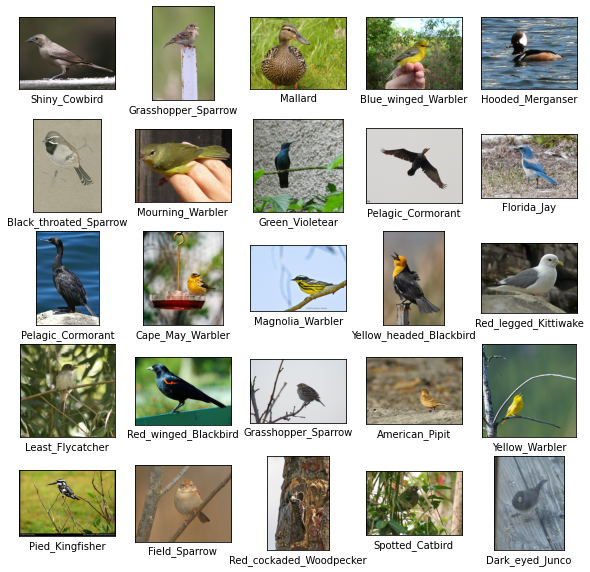

In [8]:
#testing imported data
print(data.images)
print(data.classes)
print(data.image_class_labels)
print(data.bounding_boxes)
print(data.train_test_split)
plot_grid_imgs(data.images.image_id)


# Data processing

In [9]:

# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)


heights = []
widths = []
def get_dims():
  for img_id in tq.tqdm(data.images.image_id):
    img = get_cv2_image(img_id)
    height, width, channels = img.shape
    heights.append(height)
    widths.append(height)
def show_dims():
  print(min(heights))
  print(min(widths))
  print(Average(heights))
  print(Average(widths))
#get_dims()
#show_dims()

In [10]:
def bound_image(img_id):
    img = get_cv2_image(img_id)
    bounding_box = get_bounding_box(img_id)
    #print(img_id,bounding_box)
    x = bounding_box.x.values[0]
    y = bounding_box.y.values[0]
    w = bounding_box.width.values[0]
    h = bounding_box.height.values[0]
    max_dim = max(w, h)
    w_diff = math.floor((w - max_dim)/2)
    h_diff = math.floor((h - max_dim)/2)
    x_srt = x+w_diff
    x_end = x+max_dim
    y_srt = y+h_diff
    y_end = y+max_dim
    if x_srt < 0:
      x_srt = x_srt - x_srt
      x_end = x_end - x_srt
    if y_srt < 0:
      y_srt = x_srt - x_srt
      y_end = x_end - x_srt
    #print(x_srt,x_end,y_srt,y_end)
    crop_img = img[y_srt:y_end,x_srt:x_end] #crops the image with respect to bounding boxes mentioned in the dataset
    return crop_img

def bound_images(image_ids, image_size):
    for img_id in tq.tqdm(image_ids):
        new_path = get_image_path(img_id,bound_fldr)
        #check if already processed
        if check_create_image_loc(new_path):
          cur_img = bound_image(img_id)
          height, width, channels = cur_img.shape
          #max_dim = max(height, width)
          #width_new = math.floor(image_size/max_dim * width)
          #height_new = math.floor(image_size/max_dim * height)
          #print(width_new, height_new)
          #resize_img = cv2.resize(cur_img, (image_size, image_size)) #resizing the cropped image so that all images have same dimensions and can easily be converted to np array 
          #also reduces the memory usage
          #took the average of all images to rezise (mean of x+width, y+height)
          #save picture to a new path
          cv2.imwrite(new_path ,cur_img)


bound_images(data.images.image_id, image_size)

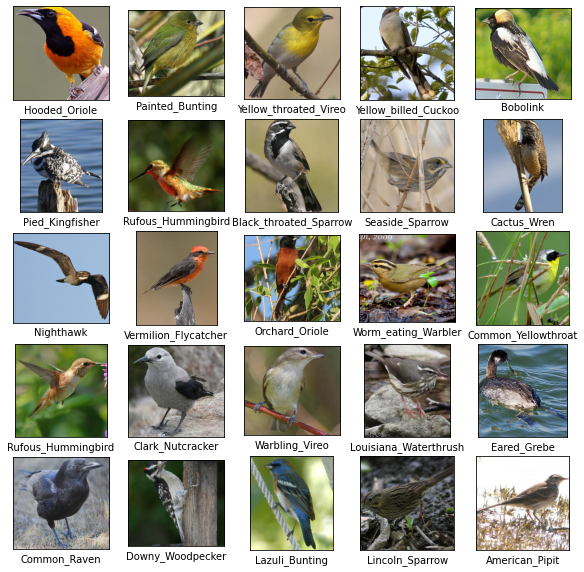

In [11]:
plot_grid_imgs(data.images.image_id, [bound_fldr])

# preprocessing

In [12]:
#Add random noise (actually, randomly change the gray value of pixels on the image to 255, which is white)
def random_noise(img_id,noise_num):
    img = get_cv2_image(img_id,fldr=bound_fldr)
    img_noise = img
    rows, cols, chn = img_noise.shape
    for i in range(noise_num):
        x = np.random.randint(0, rows)
        y = np.random.randint(0, cols)
        img_noise[x, y, :] = 255
    return img_noise

def gamma_transform(img_id):
    img = get_cv2_image(img_id,flags=cv2.IMREAD_GRAYSCALE,fldr=bound_fldr)
    fi = img / 255.0
    gamma = 0.4
    out_img = np.power(fi, gamma)
    return out_img

def pic_transpose(img_id):
    img = get_image(img_id,fldr=bound_fldr)
    #transpose_img = img.transpose(Image.ROTATE_90)
    transpose_img = img.transpose(Image.ROTATE_180)
    #transpose_img = img.transpose(Image.ROTATE_270)
    return transpose_img

def get_imghist(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img],[0],None,[256],[0,255])
    return hist

def cal_equalhist(img_id):
    img=get_cv2_image(img_id,fldr=bound_fldr)
    if len(img.shape) == 3:
         img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    h,w = img.shape[:2]
    grathist = get_imghist(img)
 
    zerosumMoment = np.zeros([256],np.uint32)
    for p in range(256):
        if p ==0:
            zerosumMoment[p] = grathist[0]
        else:
            zerosumMoment[p] = zerosumMoment[p-1] +grathist[p]
 
    output_q = np.zeros([256],np.uint8)
    cofficient = 256.0/(h*w)
    for p in range(256):
        q = cofficient *float(zerosumMoment[p]) - 1
        if q >= 0:
            output_q[p] = math.floor(q)
        else:
            output_q[p] = 0
 
    equalhistimage = np.zeros(img.shape,np.uint8)
    for i in range(h):
        for j in range(w):
            equalhistimage[i][j] = output_q[img[i][j]]
    return equalhistimage

#bound_fldr = process_fldr + 'bound/'
#noise_fldr = process_fldr + 'noise/'
#gamma_fldr = process_fldr + 'gamma/'
#transpose_fldr = process_fldr + 'transpose/'
#equalhist_fldr =  process_fldr + 'equalhist/'


def preprocess_images(image_ids):
  for img_id in tq.tqdm(image_ids):
    noise_path = get_image_path(img_id,noise_fldr)
    if check_create_image_loc(noise_path):
      noise_img = random_noise(img_id,3000)
      cv2.imwrite(noise_path, noise_img)
    
    gamma_path = get_image_path(img_id,gamma_fldr)
    if check_create_image_loc(gamma_path):
      gamma_img = gamma_transform(img_id)
      cv2.imwrite(gamma_path,gamma_img)
    
    #transpose_path = get_image_path(img_id,transpose_fldr)
    #if check_create_image_loc(transpose_path):
      #transpose_img = pic_transpose(img_id)
      #transpose_img.save(transpose_path)

    equalhist_path = get_image_path(img_id,equalhist_fldr)
    if check_create_image_loc(equalhist_path):
      equalhist_img = cal_equalhist(img_id)
      cv2.imwrite(equalhist_path,equalhist_img)

#not implemented atm
#preprocess_images(data.images.image_id)

In [13]:

#plot_grid_imgs(data.images.image_id, [bound_fldr, noise_fldr, gamma_fldr, transpose_fldr, equalhist_fldr])

# datasets

In [14]:
img1 = get_cv2_image(1, fldr=bound_fldr)
img2 = get_cv2_image(1, fldr=gamma_fldr)
img3 = np.concatenate([img1, img2], axis=2)
print(np.shape(img1))
print(np.shape(img2))
print(np.shape(img3))

(319, 325, 3)
(319, 325, 3)
(319, 325, 6)


In [15]:
categorical_ids = [str(i-1) for i in data.classes.class_id] #data.classes.class_id.to_list()
def get_dataset(subset):
  return keras.preprocessing.image_dataset_from_directory(
    bound_fldr, labels='inferred', label_mode='categorical', class_names=categorical_ids,
    color_mode='rgb', image_size=(image_size,image_size), smart_resize=True,
    validation_split=0.2, subset=subset, 
    shuffle=True, seed=123)

In [16]:
train_ds = get_dataset('training')
temp_ds = get_dataset('validation')
dev_ds = temp_ds.shard(2, 0)
test_ds = temp_ds.shard(2, 1)

Found 11788 files belonging to 200 classes.
Using 9431 files for training.
Found 11788 files belonging to 200 classes.
Using 2357 files for validation.


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache()
#dev_ds = dev_ds.cache()
#test_ds = test_ds.cache()

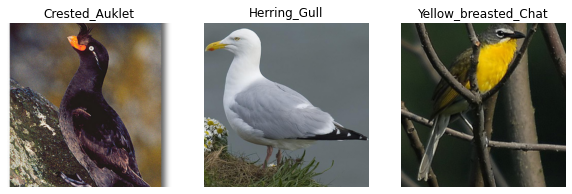

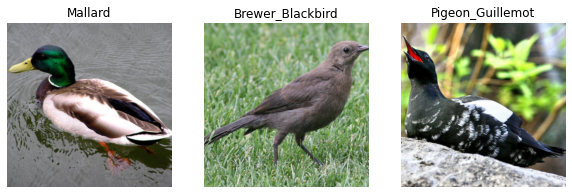

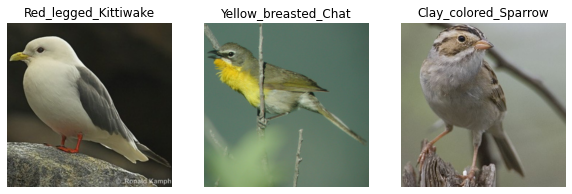

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(get_class_name(np.argmax(labels[i])+1))
    plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in dev_ds.take(1):
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(get_class_name(np.argmax(labels[i])+1))
    plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(get_class_name(np.argmax(labels[i])+1))
    plt.axis("off")

# Implimentation

In [24]:
def log_loc():
  return "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"

def create_checkpoint(name):
  path = name + '_best_model.hdf5'
  return ModelCheckpoint(filepath=path,
                              monitor='val_loss',
                              verbose=2, 
                              save_best_only=True,
                              mode='min')
def create_tensorboard(logdir):
  # Define the Keras TensorBoard callback.
  return keras.callbacks.TensorBoard(log_dir=logdir+ "fit/")


def build_model(num_classes, img_size, name, img_augmentation,net,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = img_augmentation(inputs)
    #EfficientNetB0 	224
    #EfficientNetB1 	240
    #EfficientNetB2 	260
    #EfficientNetB3 	300
    #EfficientNetB4 	380
    #EfficientNetB5 	456
    #EfficientNetB6 	528
    #EfficientNetB7 	600
    
    model = net(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name=name + "_EfficientNet5")
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

def unfreeze_model(model,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
def plot_hist(hist):
  val_accuracy = hist.history['val_accuracy']
  accuracy = hist.history['accuracy']

  plt.plot(accuracy, label='accuracy')
  plt.plot(val_accuracy, label = 'val_accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(["Train", "Validation"], loc="upper left")

def model_acc(model,ds):
  test_loss, test_acc = model.evaluate(ds, verbose=2)
  print(test_loss,test_acc)

def transfer_learning_stage1(model,log_path, batch_size=100, epochs=10):
  tensorboard = create_tensorboard(log_path)
  checkpoint = create_checkpoint(model.name+"_stage1")
  
  hist = model.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=dev_ds, callbacks=[tensorboard,checkpoint])

  plot_hist(hist)
  model_acc(model, test_ds)
  %tensorboard --log_path logs
  return hist

def transfer_learning_stage2(model,log_path, batch_size=100, epochs=10, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)):
  tensorboard = create_tensorboard(log_path)
  checkpoint = create_checkpoint(model.name+"_stage2")
  
  unfreeze_model(model,optimizer=optimizer)

  hist = model.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=dev_ds, callbacks=[tensorboard,checkpoint])

  plot_hist(hist)
  model_acc(model, test_ds)
  %tensorboard --log_path logs
  return hist


In [20]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, decay=0.01)
#optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2)
model_B5_b =  build_model(len(categorical_ids),image_size,'model_B5_b',img_augmentation,keras.applications.EfficientNetB5,optimizer)
model_B5_b.summary()

Model: "model_B5_b_EfficientNet5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 456, 456, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 456, 456, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization (Normalization)   (None, 456, 456, 3)  7           rescaling[0][0]                  
___________________________________________________________________________

D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
295/295 [==============================] - 227s 733ms/step - loss: 2.6196 - accuracy: 0.3993 - val_loss: 1.6410 - val_accuracy: 0.6689

Epoch 00001: val_loss improved from inf to 1.64105, saving model to model_B5_b_EfficientNet5_stage1_best_model.hdf5
Epoch 2/10
295/295 [==============================] - 222s 753ms/step - loss: 1.3619 - accuracy: 0.6385 - val_loss: 1.1259 - val_accuracy: 0.7010

Epoch 00002: val_loss improved from 1.64105 to 1.12595, saving model to model_B5_b_EfficientNet5_stage1_best_model.hdf5
Epoch 3/10
295/295 [==============================] - 227s 768ms/step - loss: 1.1759 - accuracy: 0.6850 - val_loss: 1.0167 - val_accuracy: 0.7365

Epoch 00003: val_loss improved from 1.12595 to 1.01668, saving model to model_B5_b_EfficientNet5_stage1_best_model.hdf5
Epoch 4/10
295/295 [==============================] - 225s 763ms/step - loss: 1.0647 - accuracy: 0.7102 - val_loss: 0.9640 - val_accuracy: 0.7331

Epoch 00004: val_loss improved from 1.01668 to 0.96399, 

TypeError: ignored

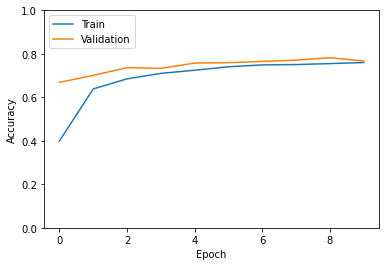

In [22]:
log_path = log_loc()
history_B5_b1 = transfer_learning_stage1(model_B5_b, log_path, batch_size=100, epochs=10)

Epoch 1/10
295/295 [==============================] - 259s 846ms/step - loss: 0.8507 - accuracy: 0.7702 - val_loss: 0.8096 - val_accuracy: 0.7889

Epoch 00001: val_loss improved from inf to 0.80956, saving model to model_B5_b_EfficientNet5_stage2_best_model.hdf5
Epoch 2/10
295/295 [==============================] - 249s 844ms/step - loss: 0.8001 - accuracy: 0.7797 - val_loss: 0.8474 - val_accuracy: 0.7889

Epoch 00002: val_loss did not improve from 0.80956
Epoch 3/10
295/295 [==============================] - 250s 846ms/step - loss: 0.7732 - accuracy: 0.7866 - val_loss: 0.8054 - val_accuracy: 0.7981

Epoch 00003: val_loss improved from 0.80956 to 0.80535, saving model to model_B5_b_EfficientNet5_stage2_best_model.hdf5
Epoch 4/10
295/295 [==============================] - 246s 832ms/step - loss: 0.7802 - accuracy: 0.7852 - val_loss: 0.8550 - val_accuracy: 0.7745

Epoch 00004: val_loss did not improve from 0.80535
Epoch 5/10
295/295 [==============================] - 242s 821ms/step - lo

TypeError: ignored

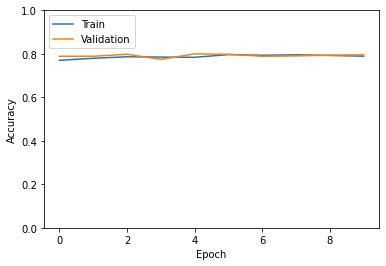

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, decay=0.01)
#optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
history_B5_b2 = transfer_learning_stage2(model_B5_b, log_path, batch_size=100, epochs=10,optimizer=optimizer)

In [25]:
model_acc(model_B5_b,dev_ds)

37/37 - 24s - loss: 0.8066 - accuracy: 0.7965
0.8066222667694092 0.7964527010917664


In [26]:
model_acc(model_B5_b,test_ds)

37/37 - 26s - loss: 0.7895 - accuracy: 0.7911
0.7894836068153381 0.7911338210105896


In [57]:
true_categories = tf.concat([xy for x, y in test_dataset], axis=0)

InvalidArgumentError: ignored

In [124]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(chain.from_iterable(listOfLists))

In [127]:
dev_pred_cats = []
dev_gold_cats = []
for batch_images, batch_labels in dev_ds:
  batch_pred = model_B5_b.predict(batch_images)
  dev_pred_cats.append(np.argmax(batch_pred, axis=1))
  dev_gold_cats.append(np.argmax(batch_labels, axis=1))

dev_gold_ids = flatten(dev_pred_cats)
dev_pred_ids = flatten(dev_gold_cats)

print(dev_gold_ids)
print(dev_pred_ids)

dev_gold = [get_class_name(x+1) for x in dev_gold_ids]
dev_pred = [get_class_name(x+1) for x in dev_pred_ids]

print("\nDev set classification report")
print(sklearn.metrics.classification_report(dev_gold,dev_pred))

[123, 46, 24, 164, 90, 65, 179, 159, 1, 44, 122, 62, 57, 167, 35, 91, 17, 84, 14, 39, 153, 49, 85, 38, 32, 147, 6, 0, 169, 101, 89, 167, 126, 36, 86, 168, 3, 16, 138, 102, 13, 70, 29, 129, 68, 67, 112, 140, 175, 39, 55, 95, 42, 44, 158, 62, 78, 72, 124, 46, 168, 95, 12, 135, 110, 192, 44, 53, 79, 36, 161, 50, 155, 142, 146, 87, 6, 180, 184, 164, 159, 116, 184, 64, 81, 38, 98, 197, 77, 83, 105, 193, 194, 84, 119, 150, 89, 157, 150, 50, 179, 74, 179, 31, 177, 138, 190, 22, 115, 20, 75, 19, 140, 0, 170, 57, 124, 136, 75, 10, 109, 61, 10, 171, 188, 36, 55, 168, 18, 20, 81, 172, 67, 160, 21, 135, 165, 100, 122, 68, 196, 192, 38, 40, 22, 60, 54, 6, 167, 135, 112, 4, 116, 109, 129, 0, 19, 40, 46, 80, 190, 69, 89, 28, 46, 49, 107, 132, 149, 53, 174, 48, 39, 32, 3, 33, 44, 23, 38, 196, 72, 168, 35, 33, 68, 122, 10, 66, 45, 18, 78, 103, 162, 189, 188, 39, 153, 42, 83, 103, 191, 103, 181, 86, 40, 0, 67, 199, 77, 131, 119, 69, 32, 77, 196, 120, 198, 73, 81, 187, 52, 148, 113, 103, 149, 143, 91, 17

D:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
test_pred_cats = []
test_gold_cats = []
for batch_images, batch_labels in test_ds:
  batch_pred = model_B5_b.predict(batch_images)
  test_pred_cats.append(np.argmax(batch_pred, axis=1))
  test_gold_cats.append(np.argmax(batch_labels, axis=1))

test_gold_ids = flatten(test_pred_cats)
test_pred_ids = flatten(test_gold_cats)

print(test_gold_ids)
print(test_pred_ids)

test_gold = [get_class_name(x+1) for x in test_gold_ids]
test_pred = [get_class_name(x+1) for x in test_pred_ids]

print("\nTest set classification report")
print(sklearn.metrics.classification_report(test_gold, test_pred))

[31, 28, 172, 152, 54, 68, 70, 112, 162, 34, 22, 75, 74, 180, 126, 179, 79, 62, 75, 68, 50, 132, 168, 170, 24, 181, 144, 53, 44, 175, 174, 114, 173, 50, 89, 46, 127, 38, 13, 66, 13, 146, 62, 157, 198, 108, 118, 124, 106, 175, 44, 94, 60, 67, 22, 171, 166, 148, 120, 103, 124, 111, 182, 95, 10, 187, 116, 192, 159, 1, 29, 160, 72, 156, 195, 197, 43, 189, 173, 64, 85, 57, 115, 77, 81, 37, 149, 150, 39, 30, 143, 20, 70, 110, 43, 62, 48, 69, 147, 124, 72, 77, 0, 153, 23, 194, 132, 37, 157, 99, 64, 30, 167, 79, 163, 150, 55, 28, 38, 96, 190, 182, 125, 103, 109, 8, 70, 130, 15, 49, 139, 126, 74, 29, 179, 77, 138, 127, 161, 72, 53, 135, 44, 21, 142, 45, 68, 122, 85, 44, 158, 191, 190, 6, 22, 132, 190, 196, 90, 147, 89, 138, 81, 30, 75, 86, 149, 100, 61, 36, 83, 64, 153, 170, 116, 180, 44, 195, 89, 105, 24, 39, 87, 130, 95, 186, 107, 131, 48, 177, 99, 60, 79, 8, 161, 74, 147, 158, 75, 56, 67, 117, 175, 63, 70, 195, 72, 132, 22, 148, 121, 71, 73, 54, 153, 56, 115, 62, 62, 164, 162, 53, 32, 93, 10

[[7 0 1 ... 0 0 0]
 [2 5 1 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


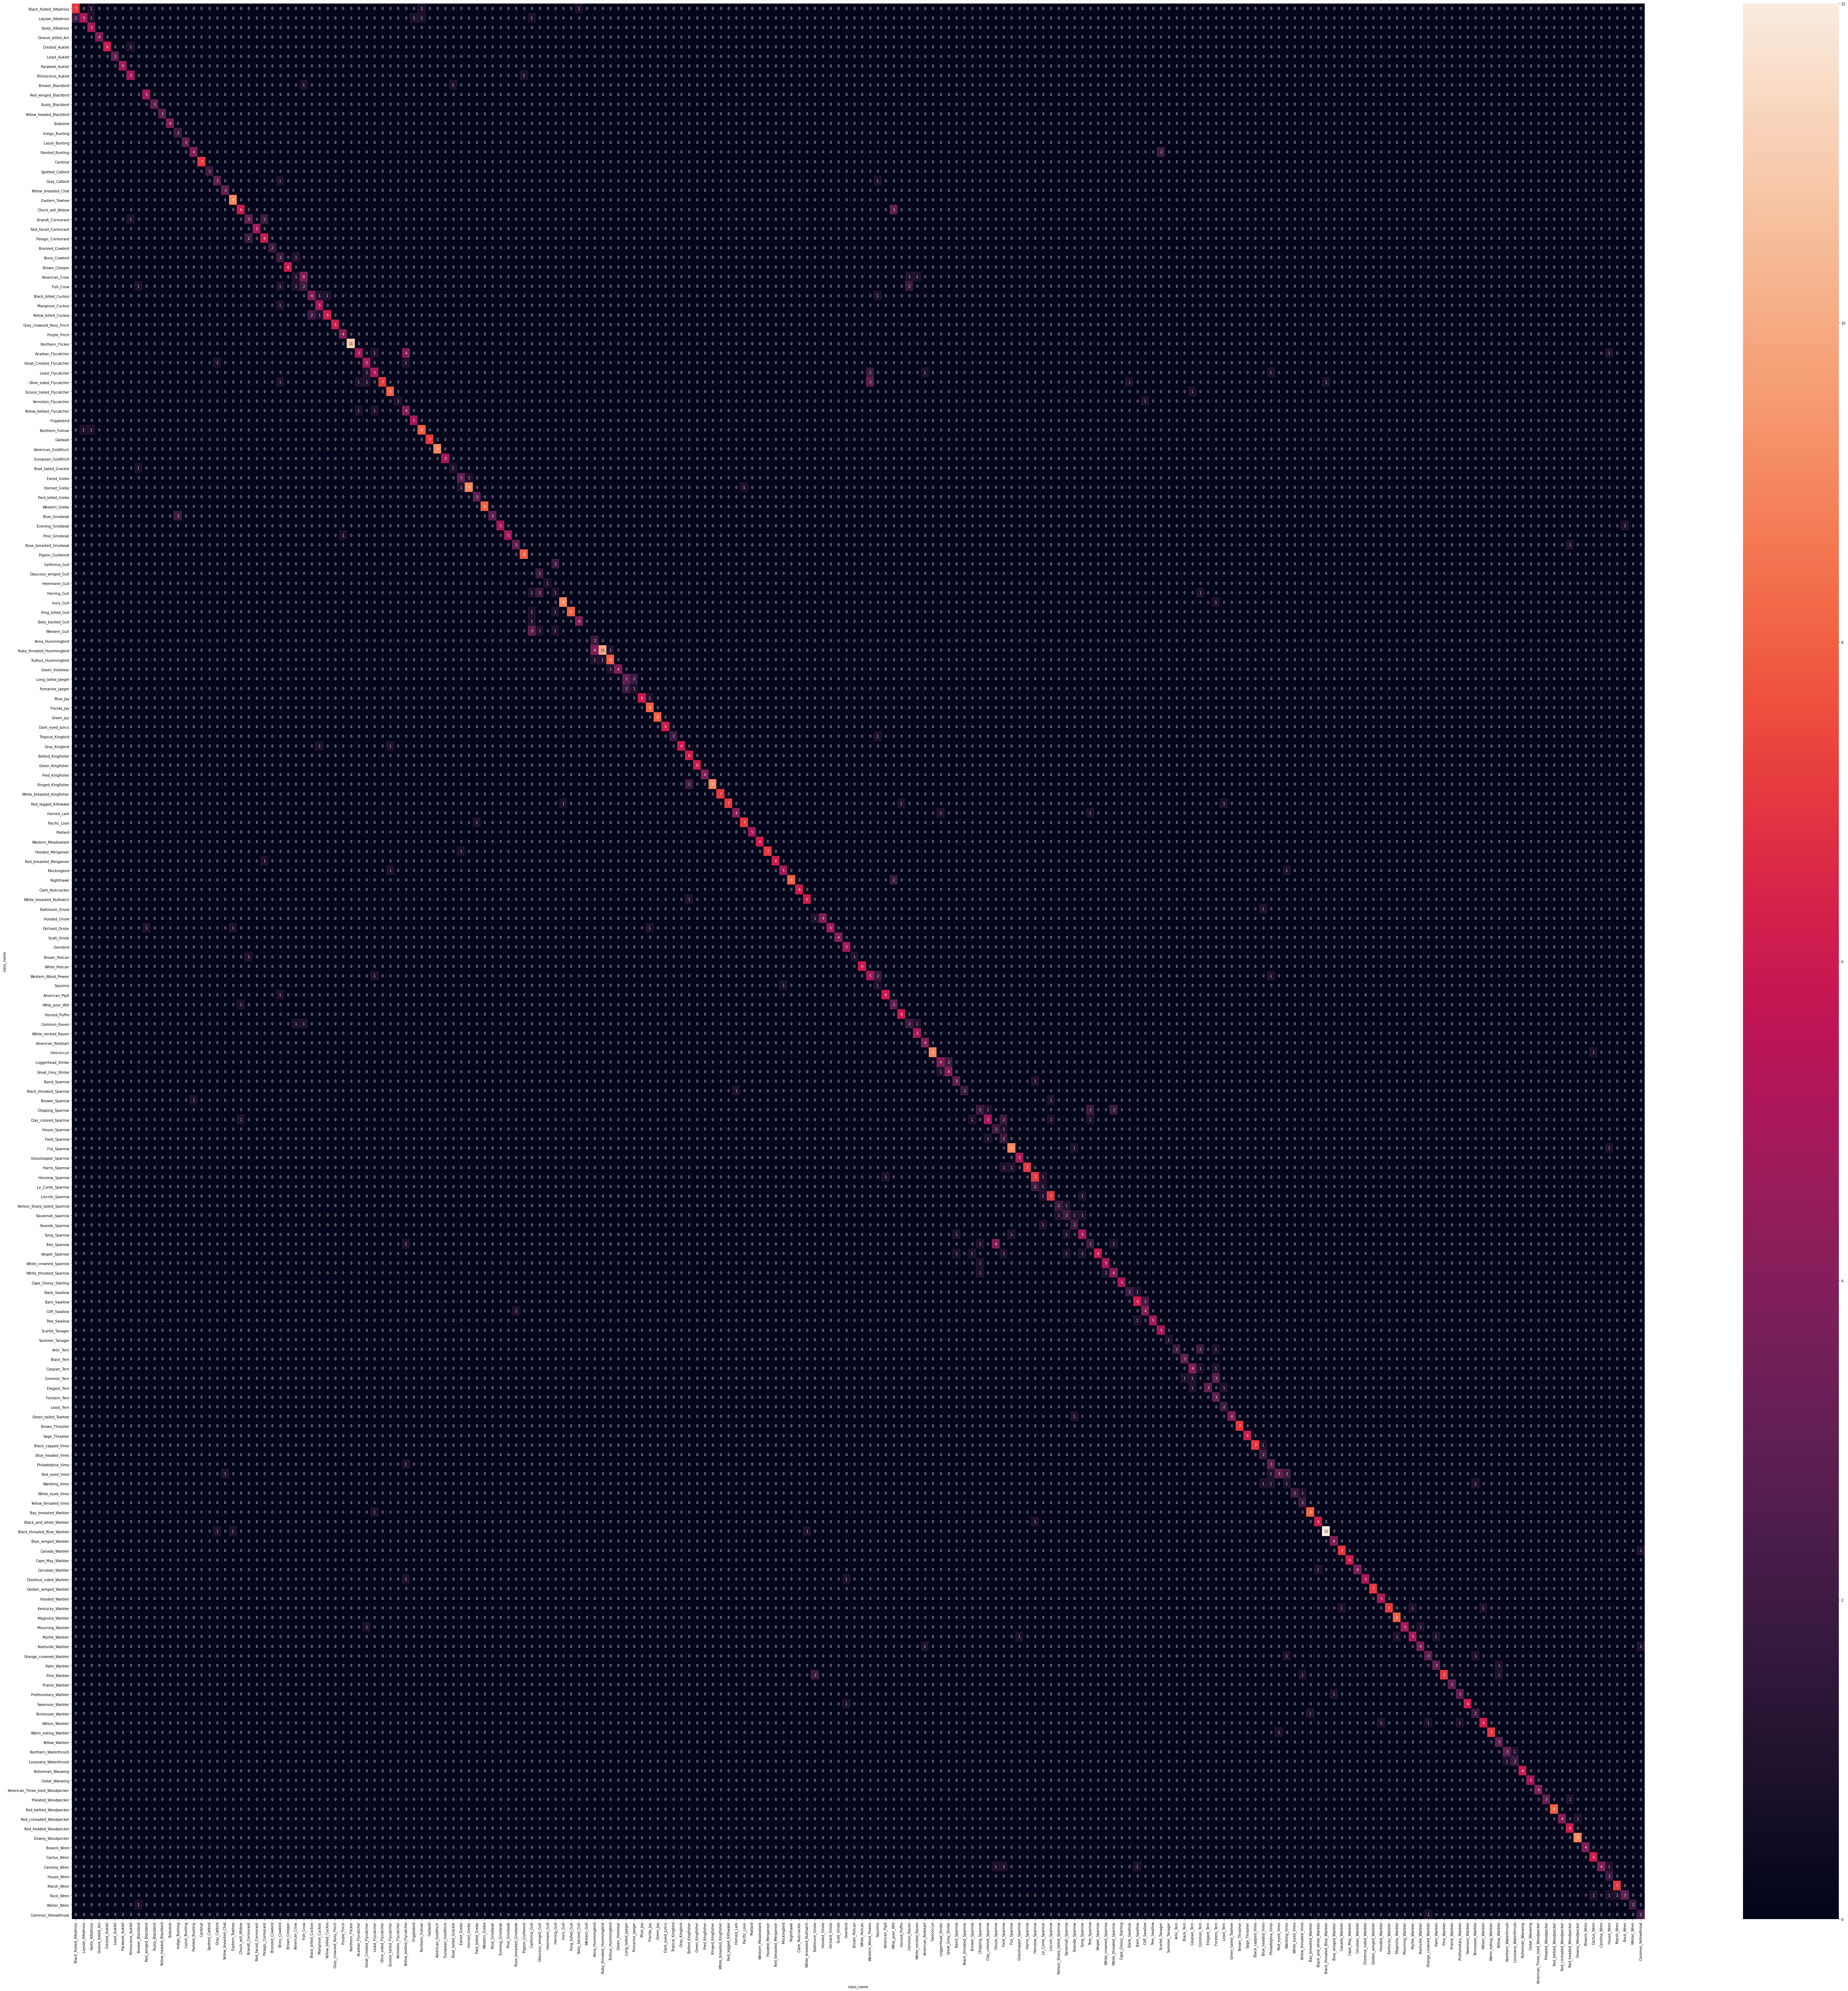

In [149]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model_B5_b, data.classes.class_name)

dev_cm = tf.math.confusion_matrix(dev_gold_ids,dev_pred_ids)
dev_cm_arr =  np.array(dev_cm)

print(dev_cm_arr)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(dev_cm_arr, index = data.classes.class_name,
                  columns = data.classes.class_name)
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

#dev_cm_plt = sklearn.metrics.plot_confusion_matrix(classifier,dev_ds,dev_gold_ids)
#dev_cm_plt.ax_.set_title("Dev set confusion matrix")

#test_cm =tf.math.confusion_matrix(test_gold,test_pred)
#print(test_cm)

#test_cm_plt = sklearn.metrics.plot_confusion_matrix(classifier,test_ds,test_gold)
#test_cm_plt.ax_.set_title("Test set confusion matrix")

